# rDCM-retNet

Regression Dynamic Causal Modeling

In [43]:
effect_size_threshold = 1

In [44]:
import os
import os.path
import numpy as np
import scipy.linalg as spl
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.io import savemat
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.patheffects as PathEffects
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.io import loadmat
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py

n_sub    = 157
# Model
n_cond   = 10
n_sess   = 10
n_rois   = 24
TR       = 1
effect_size_threshold = 1


# Index dictionary
conf = {
        'tasks'   : ['vfm','movie','rest'], 
        'eccen'   : ['fovea','para-fovea'], 
        'fovea'   : [ 
                    [0,2,4,6,8,10,12,14,16,18,20,22],  #  < fovea
                    [1,3,5,7,9,11,13,15,17,19,21,23],   #  > fovea
                    ],
        'roiname' : ['V1','V2','V3'], 
        'rois'    : [
                    [0,1,2,3,12,13,14,15],   # V1
                    [4,5,6,7,16,17,18,19],   # V2
                    [8,9,10,11,20,21,22,23]  # V3
                    ],
        'task'    : [
                    [0,1],     # retinotopy
                    [2,3,4,5], # movie watching
                    [6,7,8,9]  # resting state
                    ],

        'hemis'   : ['left', 'right'],
        }


# Time series 
# ---------------------------------------------------------------------------------------------------------------------------

task_ID_1  = ['tfMRI_RETBAR1_7T_AP',
              'tfMRI_RETBAR2_7T_PA'
              ]

task_ID_2  = ['tfMRI_MOVIE1_7T_AP',
              'tfMRI_MOVIE2_7T_PA',
              'tfMRI_MOVIE3_7T_PA',
              'tfMRI_MOVIE4_7T_AP', 
             ]

task_ID_3  = ['rfMRI_REST1_7T_PA',
              'rfMRI_REST2_7T_AP',
              'rfMRI_REST3_7T_PA',
              'rfMRI_REST4_7T_AP'
             ]

task_ID = task_ID_1 + task_ID_2 + task_ID_3


## Effect sizes
def cohen_d(group1, group2):
    # Calculating means of the two groups
    mean1, mean2 = np.nanmean(group1), np.nanmean(group2)
     
    # Calculating pooled standard deviation
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
     
    # Calculating Cohen's d
    #d = (mean1 - mean2) / pooled_std

    # Hedges correction 
    d = ((mean1 - mean2) / pooled_std)*((len(group1) + len(group2) - 3) / (len(group1)+len(group2)-2.25))
    
    # Welch's correction
    #d = np.abs(np.mean(group1) - np.mean(group2)) / np.sqrt( (np.var(group1) + np.var(group2)) /2 )

    return d

### Load data


In [45]:

fileobj     = open('/home/nicolas/Documents/RetNet/retNet_analyses/HCP_7T_prep/subj_id.txt')
data        = fileobj.read()
subject_ID  = data.split('\n')

# Subjects x Task
scans    = [i for i in range(n_sub*10)]
scan_idx = np.zeros((10,n_sub)).astype(np.uint)
for n in range(10):
    scan = [x for x in scans if x%10 ==n]
    scan_idx[n,:] = scan
print('Subjects x Task :', scan_idx)


prep_pth = '/home/nicolas/Documents/RetNet/ret-EC/'
#time_series = {'data': data, 'scan_idx': scan_idx}
fname = os.path.join(prep_pth + 'tseries_24rois_allsubjects.npy')
time_series = np.load(fname,allow_pickle=True).item()
data = time_series['data']
scan_idx = time_series['scan_idx']
print(scan_idx.shape)


Subjects x Task : [[   0   10   20 ... 1540 1550 1560]
 [   1   11   21 ... 1541 1551 1561]
 [   2   12   22 ... 1542 1552 1562]
 ...
 [   7   17   27 ... 1547 1557 1567]
 [   8   18   28 ... 1548 1558 1568]
 [   9   19   29 ... 1549 1559 1569]]
(10, 157)


### Save data and compute rDCM in Matlab

In [46]:
#tSeries = data[scan_idx[:,:]]

#sio.savemat(prep_pth + 'HCP_ecv24rois.mat', {'data': tSeries, 'scan_idx': scan_idx})


for i_sess in range(10):
    for i_sub in range(n_sub):
        tSeries = data[scan_idx[i_sess,i_sub]]
        sio.savemat(prep_pth + 'retdata/sorted/tSeries_subj-' + str(i_sub+1) + '_scan-' +  str(i_sess+1) + '_24rois_allsubjects.mat', {'data': tSeries})

        

### Matlab code for rDCM

In [47]:
'''
clear al
close all
cd('/home/nicolas/Documents/RetNet/ret-EC/')

addpath(genpath('tapas'))

rng(2406,'twister')


% specify the options for the rDCM analysis:

options.SNR               = 3;
options.y_dt               = 1;
options.p0_all            = 0.15;  % single p0 value (for computational efficiency)
options.iter                = 1000;
options.filter_str         = 5;
options.restrictInputs  = 1;

type = 'r';  % empirical

corrected = 0;


args.a = [] %mask_C


% run rDCM analysis with ridge (1) or sparsity constraints (2) (performs model inversion)
method = 1

HCP_data = '/home/nicolas/Documents/RetNet/ret-EC/'



pth =    '/home/nicolas/Documents/RetNet/ret-EC/dcm_results/HCP/'





%% Model estimation
for i_subj = 1:150
    
    
    
    fprintf(num2str(i_subj))
    
    % get time
    currentTimer = tic
    
    
    for i_sess = 1:10
        
        tSeries{i_subj,i_sess} = load(strcat(HCP_data, 'tSeries_subj-',  num2str(i_subj), '_scan-', num2str(i_sess), '_24rois_allsubjects.mat'));
        
        
        ts = cell2mat( tSeries(i_subj,i_sess));
        
        % Data structure
        Y.y  = ts.data.';
        Y.dt = 1 ;  % TR
        dim = size(Y.y.');
        
        % Input structure
        %..... random or GLM (task) or zeros (resting state)  ¯\_('_')_/¯  ?
        
        %U.u = rand(dim(1),dim(2))   % random input seem to work better
        %U.u = zeros(dim(1),dim(2))
        %U.u = randi(16*dim(1),dim(2))
        U = [] ;  % resting state
        
        % Arguments for model specification. May contain custom network architectures (i.e.,
        % endogenous connectivity and driving inputs) that overwrite the default settings.
        args = [];
        
        %[ DCM ] = tapas_rdcm_model_specification(Y, U, args)    %  visual field mapping, random sem to work better
        [ DCM ] = tapas_rdcm_model_specification(Y, [], args);  % resting state
        
        [output{i_subj,i_sess}, opt{i_subj,i_sess}] = tapas_rdcm_estimate(DCM, type, options, method);
        
        
        
        % No input model
        y         = abs(output{i_subj,i_sess}.signal.yd_source_fft);
        y_pred = abs(output{i_subj,i_sess}.signal.yd_pred_rdcm_fft);
        
        mdl = fitlm(y,y_pred);
        R2_adj = mdl.Rsquared.Adjusted;
        
        
        EC= output{i_subj,i_sess}.Ep.A;  % Effective connectivity   ¯\_('_')_/¯  ?
        %figure,
        %imagesc(EC)
        %caxis([-1*max(max(abs(EC-diag(diag(EC))))) max(max(abs(EC-diag(diag(EC)))))])
        
        S = EC(sub2ind(size(EC),1:size(EC,1),1:size(EC,2)));  % EC diagonal,  ~Sigma ?  ¯\_('_')_/¯  ?
        %figure, plot(S)
        %S_dcm(i_subj,i_sess,:) = S;
        
        % EC without diagonal
        %EC = EC_
        EC(sub2ind(size(EC),1:size(EC,1),1:size(EC,2))) = 0;
        %EC_dcm(i_subj,i_sess,:,:) = EC;
        
        
        fname = [pth 'R2_adj_dcm_sess-' num2str(i_sess) '_subj-' num2str(i_subj) '.mat']
        save(fname,'R2_adj','-v7.3');
        
        %EC_dcm = zeros(150,10,24,24)
        %S_dcm   = zeros(150,10,24)
        fname = [pth 'S_dcm_sess-' num2str(i_sess) '_subj-' num2str(i_subj) '.mat']
        save(fname,'S','-v7.3');
        
        fname = [pth 'EC_dcm_sess-' num2str(i_sess) '_subj-' num2str(i_subj) '.mat']
        save(fname,'EC','-v7.3');
        
        
        
        
    end
    clear output opt mdl tSeries EC_dc
    % output elapsed time
    
    toc(currentTimer)
end




'''

"\nclear al\nclose all\ncd('/home/nicolas/Documents/RetNet/ret-EC/')\n\naddpath(genpath('tapas'))\n\nrng(2406,'twister')\n\n\n% specify the options for the rDCM analysis:\n\noptions.SNR               = 3;\noptions.y_dt               = 1;\noptions.p0_all            = 0.15;  % single p0 value (for computational efficiency)\noptions.iter                = 1000;\noptions.filter_str         = 5;\noptions.restrictInputs  = 1;\n\ntype = 'r';  % empirical\n\ncorrected = 0;\n\n\nargs.a = [] %mask_C\n\n\n% run rDCM analysis with ridge (1) or sparsity constraints (2) (performs model inversion)\nmethod = 1\n\nHCP_data = '/home/nicolas/Documents/RetNet/ret-EC/'\n\n\n\npth =    '/home/nicolas/Documents/RetNet/ret-EC/dcm_results/HCP/'\n\n\n\n\n\n%% Model estimation\nfor i_subj = 1:150\n    \n    \n    \n    fprintf(num2str(i_subj))\n    \n    % get time\n    currentTimer = tic\n    \n    \n    for i_sess = 1:10\n        \n        tSeries{i_subj,i_sess} = load(strcat(HCP_data, 'tSeries_subj-',  num2str

### Load rDCM results

In [48]:
n_cond       = 10
N_rois       = 24
depth_correction = False

results_pth   = '/home/nicolas/Documents/RetNet/ret-EC/dcm_results/HCP/'
data_dir = pjoin(dirname(sio.__file__), 'matlab', 'tests', 'data')

## Load rDCM results fro matlab files
S_dcm       = np.zeros([n_cond,n_sub,N_rois])      
EC_dcm      = np.zeros([n_cond,n_sub,N_rois,N_rois])     
EC_offDiag  = np.zeros([n_cond,n_sub,N_rois,N_rois])     
EC_normed   = np.zeros([n_cond,n_sub,N_rois,N_rois]) 
EC_asym     = np.zeros([n_cond,n_sub])
EC_r2adj    = np.zeros([n_cond,n_sub])


for i_cond in range(10):
    for i_sub in range(n_sub):
        
            
        fname = results_pth + 'S_dcm_sess-' + str(i_cond+1) + '_subj-' + str(i_sub+1) + '.mat'
        mat_fname = pjoin(fname)
        data = h5py.File(mat_fname,'r')
        S_dcm[i_cond,i_sub,:] = np.squeeze(data.get('S'))
        
        fname = results_pth + 'EC_dcm_sess-' + str(i_cond+1) + '_subj-' + str(i_sub+1) + '.mat'
        mat_fname = pjoin(fname)
        data = h5py.File(mat_fname,'r')
        EC_dcm[i_cond,i_sub,:,:] = np.squeeze(data.get('EC'))  
        
        fname = results_pth + 'R2_adj_dcm_sess-' + str(i_cond+1) + '_subj-' + str(i_sub+1) + '.mat'
        mat_fname = pjoin(fname)
        data = h5py.File(mat_fname,'r')
        EC_r2adj[i_cond,i_sub] = np.squeeze(data.get('R2_adj'))   




for i_cond in range(10):
    for i_sub in range(n_sub):

        '''
        EC      = np.copy(EC_dcm[i_cond,i_sub,:,:])

        np.fill_diagonal(EC,0)

        mask_offdiag = ~np.eye(EC.shape[0],dtype=bool)

        EC_mean = EC[mask_offdiag].mean()

        EC_std = EC[mask_offdiag].std()

        EC_normed[i_cond,i_sub,:,:] = (EC - EC_mean) / EC_std
    
        '''
        EC_      = EC_dcm[i_cond,i_sub,:,:]
        np.fill_diagonal(EC_, 0)
        #EC_offDiag[i_cond,i_sub,:,:] = EC_
        
        EClinks = EC_[~np.eye(EC_.shape[0],dtype=bool)].reshape(EC_.shape[0],-1) # ignore diagonal
        EClinks = EClinks.flatten()
        ECflat  = EC_.flatten()
        #ECnorm  = ECflat / sum(EClinks) # within hemispheres
        ECnorm  = ECflat / sum(EC_dcm[i_cond,:,:,:].flatten())  # across hemispheres
        ECnorm  = ECnorm.reshape((N_rois, N_rois))
        #EC_normed[i_cond,i_sub,:,:] = np.absolute(ECnorm)  
        np.fill_diagonal(ECnorm, 0)
        EC_normed[i_cond,i_sub,:,:] = ECnorm
        #EC_asym[i_cond,i_sub]       = asym(ECnorm)
        #print(conf['tasks'][i_cond], f'{i_sub+1}, \t, Matrix asymmetry:',EC_asym[i_cond,i_sub])
       
print('EC shape', EC_normed.shape)


EC shape (10, 157, 24, 24)


##

In [49]:


# Subject index to be removed
subject_index_to_remove = 114

# Remove the subject's data
EC_normed = np.delete(EC_normed, subject_index_to_remove, axis=1)
EC_r2adj = np.delete(EC_r2adj, subject_index_to_remove, axis=1)
S_dcm = np.delete(S_dcm, subject_index_to_remove, axis=1)

# Squeeze out any singleton dimensions if necessary
EC_normed = np.squeeze(EC_normed)

print("Shape after removing subject:", EC_normed.shape)

Shape after removing subject: (10, 156, 24, 24)


In [50]:
pth         = '/home/nicolas/Documents/RetNet/ret-EC/new_results/'

appendix = 'rDCM'
np.save(os.path.join(pth,'EC_normed' + appendix + '.npy'), EC_normed)
np.save(os.path.join(pth,'EC_r2adj' + appendix + '.npy'), EC_r2adj)
np.save(os.path.join(pth,'S_dcm' + appendix + '.npy'), S_dcm)

## Plot results

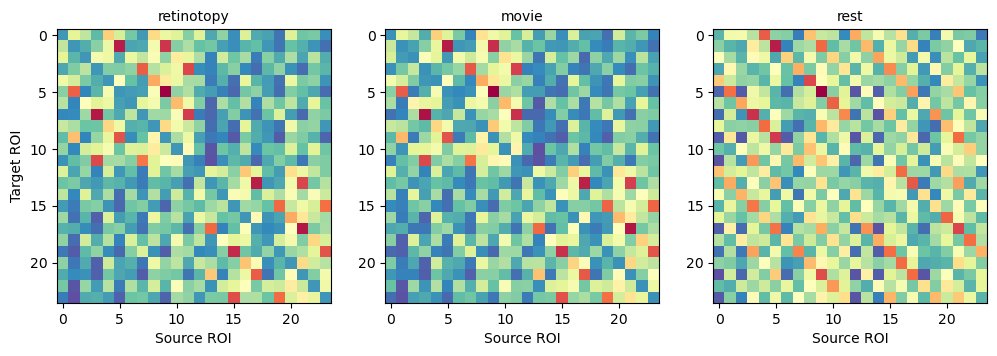

In [51]:
EC_normed.shape 
fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()


# =============================================================================
plt.sca(axs[0])
plt.imshow(np.mean(EC_normed[0,:,:,:],axis=0).T,cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('retinotopy', fontsize=10)

plt.sca(axs[1])
plt.imshow(np.mean(EC_normed[1,:,:,:],axis=0).T, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('movie', fontsize=10)


plt.sca(axs[2])
plt.imshow(np.mean(EC_normed[2,:,:,:],axis=0).T, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('rest', fontsize=10)
plt.show()

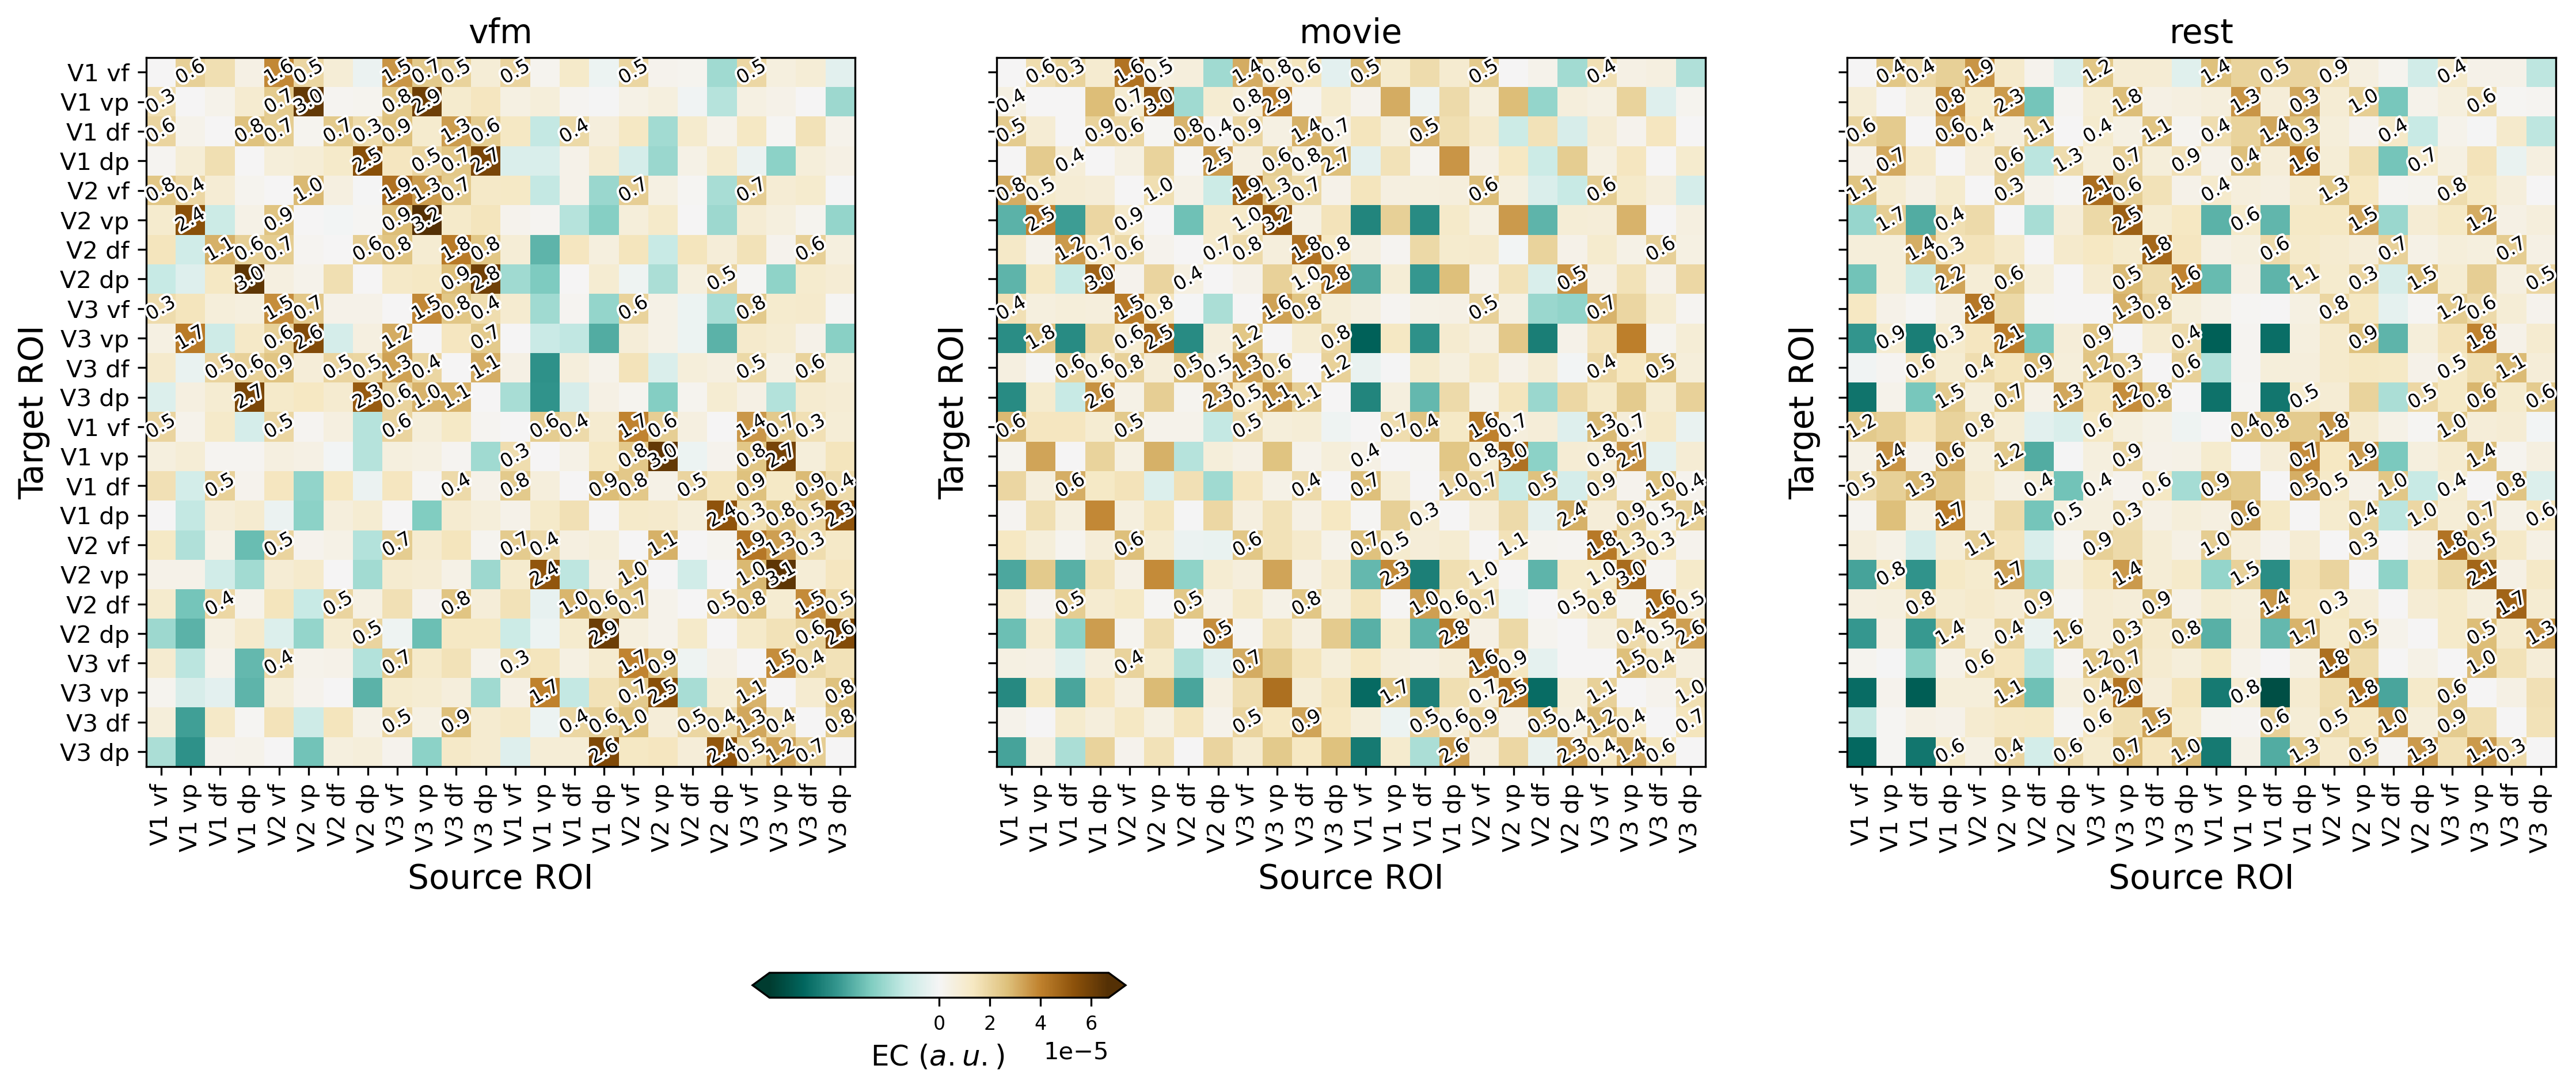

In [52]:

import matplotlib.patheffects as PathEffects
import matplotlib.colors as colors


n_cond = 3
effect_size_threshold = 0.3

EC = EC_normed



rois_sorted = [
        'V1 vf',
        'V1 vp',
        'V1 df', 
        'V1 dp',
        'V2 vf',
        'V2 vp',
        'V2 df', 
        'V2 dp',
        'V3 vf',
        'V3 vp',
        'V3 df', 
        'V3 dp',
        'V1 vf',
        'V1 vp',
        'V1 df', 
        'V1 dp',
        'V2 vf',
        'V2 vp',
        'V2 df', 
        'V2 dp',
        'V3 vf',
        'V3 vp',
        'V3 df', 
        'V3 dp']

## Effect sizes
def cohen_d(group1, group2):
    # Calculating means of the two groups
    mean1, mean2 = np.nanmean(group1), np.nanmean(group2)
     
    # Calculating pooled standard deviation
    std1, std2 = np.nanstd(group1, ddof=1), np.nanstd(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
     
    # Calculating Cohen's d
    #d = (mean1 - mean2) / pooled_std

    # Hedges correction 
    d = ((mean1 - mean2) / pooled_std)*((len(group1) + len(group2) - 3) / (len(group1)+len(group2)-2.25))
    
    # Welch's correction
    #d = np.abs(np.mean(group1) - np.mean(group2)) / np.sqrt( (np.var(group1) + np.var(group2)) /2 )

    return d


effect_sizes = np.zeros((n_cond,n_rois,n_rois))

fig, ax = plt.subplots(1,n_cond, figsize=(18,6), dpi=300,facecolor="w")

EC_min  = np.min(np.nanmean(EC_normed,axis=1).flatten())
EC_max  = np.max(np.nanmean(EC_normed,axis=1).flatten())

#EC_min  = np.min(EC_normed.flatten())
#EC_max  = np.max(EC_normed.flatten())



# Compute Cohen's d effect sizes
for i_cond in range(n_cond):

    idx = conf['task'][i_cond]

    for roi_p in range(n_rois):
        for roi_q in range(n_rois):
            effect_sizes[i_cond,roi_p,roi_q] = cohen_d(EC_normed[i_cond,:,roi_p,roi_q],EC_normed[i_cond,:,:,:].flatten())

        
   
    divnorm = colors.TwoSlopeNorm(vmin=EC_min, vcenter=0, vmax=EC_max)

    im = ax[i_cond].imshow(np.mean(np.mean(EC[idx,:,:,:],axis=0),axis=0).T, norm=divnorm, cmap='BrBG_r')
    #im = ax[i_cond].imshow(np.mean(EC_normed[i_cond,:,:,:],axis=0).T, norm=divnorm, cmap='BrBG_r')
   
    for roi_p in range(n_rois):
        for roi_q in range(n_rois):
            if effect_sizes[i_cond,roi_p,roi_q] >= effect_size_threshold:
                if roi_p > roi_q:
                    txt = ax[i_cond].text(roi_p, roi_q, f'{effect_sizes[i_cond,roi_p,roi_q]:.1f}', ha='center', va='center', color='black', fontsize=8, rotation=30)
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                if roi_p < roi_q:
                    txt = ax[i_cond].text(roi_p, roi_q, f'{effect_sizes[i_cond,roi_p,roi_q]:.1f}', ha='center', va='center', color='black', fontsize=8, rotation=30)
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
    ax[i_cond].set_xlabel('Source ROI', fontsize=14)
    ax[i_cond].set_xticks(np.arange(len(rois_sorted)))
    ax[i_cond].set_xticklabels(labels=rois_sorted, rotation=90)
    ax[i_cond].set_ylabel('Target ROI', fontsize=14)
    ax[i_cond].set_yticks(np.arange(len(rois_sorted)))
    ax[i_cond].set_yticklabels(labels=rois_sorted, rotation=0)
    if i_cond != 0:
        ax[i_cond].set_yticks(np.arange(len(rois_sorted)))
        ax[i_cond].set_yticklabels(labels=rois_sorted, rotation=0)
        labels = [item.get_text() for item in ax[i_cond].get_yticklabels()]
        empty_string_labels = ['']*len(labels)
        ax[i_cond].set_yticklabels(empty_string_labels)
    ax[i_cond].set_title(conf['tasks'][i_cond], fontsize=14)
    shift = 0#i_cond*0.425
    if i_cond == 0:
        cbar = plt.colorbar(im,cax = fig.add_axes([0.32+shift, -0.07, 0.12, 0.024 ]),extend='both',orientation='horizontal')     
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('EC ($a.u.$) ',fontsize=12)




(10, 156, 24, 24)


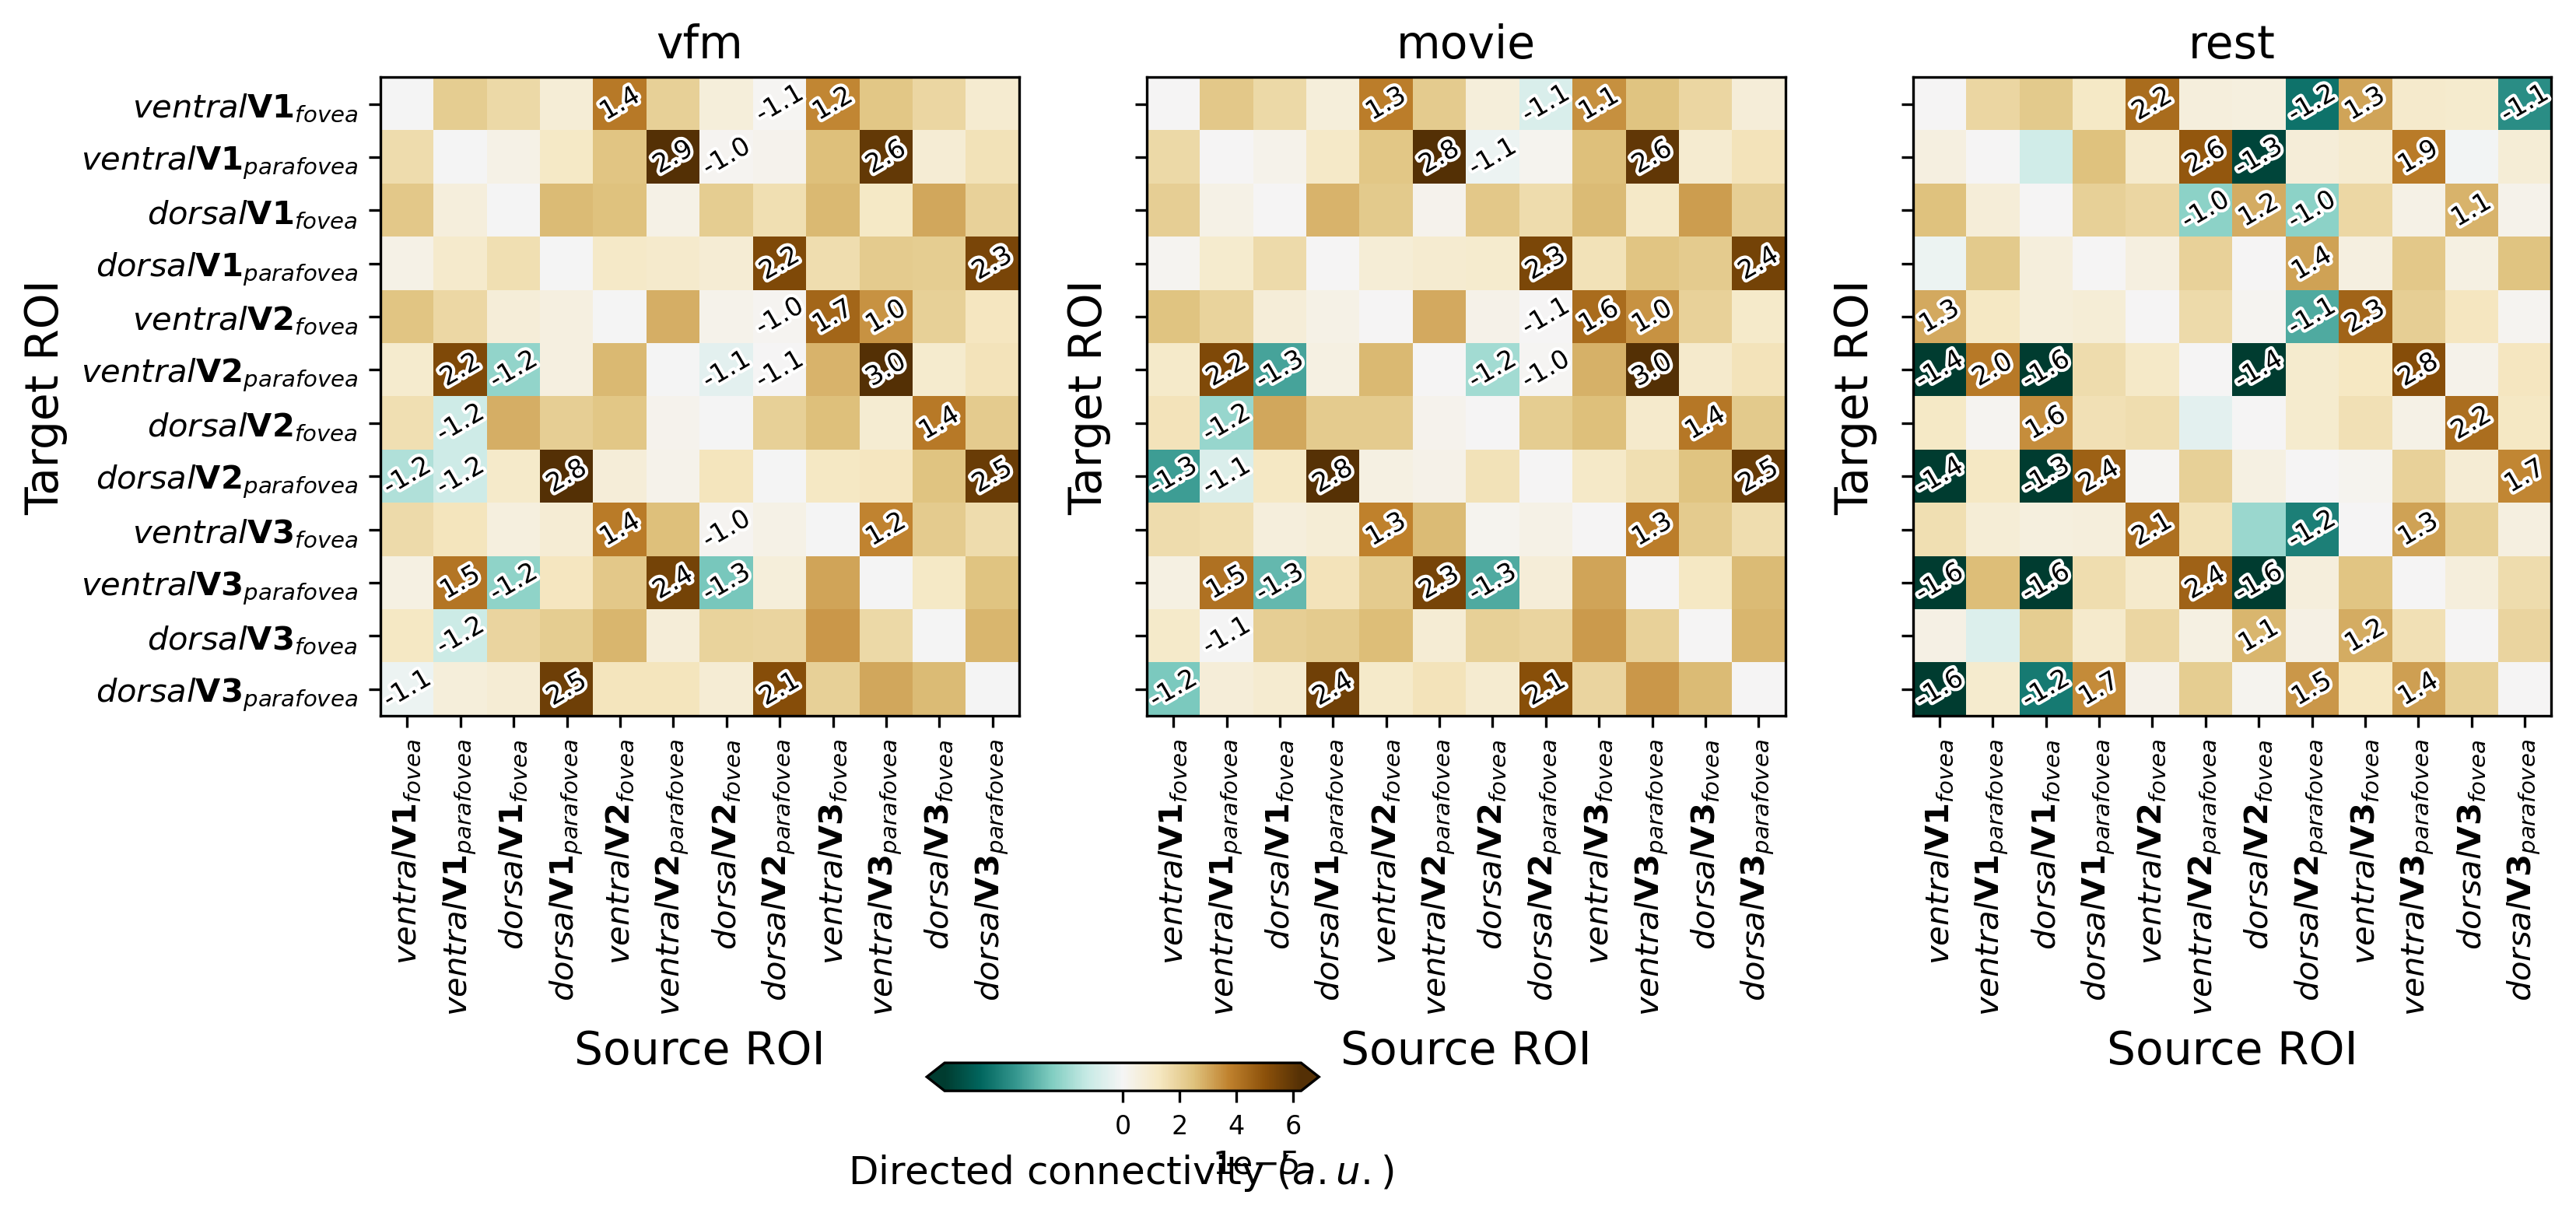

In [53]:
effect_size_threshold = 1
n_rois = 12

rois_sorted = ['$ventral \mathbf{V1}_{fovea}$',
        '$ventral \mathbf{V1}_{parafovea}$',
        '$dorsal \mathbf{V1}_{fovea}$',
        '$dorsal \mathbf{V1}_{parafovea}$',
        '$ventral \mathbf{V2}_{fovea}$', 
        '$ventral \mathbf{V2}_{parafovea}$',
        '$dorsal \mathbf{V2}_{fovea}$', 
        '$dorsal \mathbf{V2}_{parafovea}$',
        '$ventral \mathbf{V3}_{fovea}$',
        '$ventral \mathbf{V3}_{parafovea}$',
        '$dorsal \mathbf{V3}_{fovea}$',
        '$dorsal \mathbf{V3}_{parafovea}$']

effect_sizes = np.zeros((n_cond,n_rois,n_rois))

print(EC_normed.shape)
EC_hemis = np.zeros([n_cond,2*n_sub,12,12])

for i_cond in range(n_cond):
    for i_sub in range(n_sub): 
        EC_hemis[i_cond,0:n_sub,:,:]       = np.nanmean(EC_normed[i_cond,:,0:12,0:12],axis=0)
        EC_hemis[i_cond,n_sub:2*n_sub,:,:] = np.nanmean(EC_normed[i_cond,:,12:24,12:24],axis=0)
        



fig, ax = plt.subplots(1,n_cond, figsize=(12,5), dpi=300,facecolor="w")

EC_min  = np.min(np.mean(EC_hemis,axis=0).flatten())
EC_max  = np.max(np.mean(EC_hemis,axis=0).flatten())


# Compute Coehens d effect sizes
for i_cond in range(n_cond):

    for roi_p in range(n_rois):
        for roi_q in range(n_rois):
            effect_sizes[i_cond,roi_p,roi_q] = cohen_d(EC_hemis[i_cond,:,roi_p,roi_q],EC_hemis[i_cond,:,:,:].flatten())

        
   
    divnorm = colors.TwoSlopeNorm(vmin=EC_min, vcenter=0, vmax=EC_max)

    #im = ax[i_cond].imshow(np.mean(EC_hemis[i_cond,:,:,:],axis=0).T, norm=divnorm, cmap='BrBG_r')
    im = ax[i_cond].imshow(np.mean(EC_hemis[i_cond,:,:,:],axis=0).T, norm=divnorm, cmap='BrBG_r')


    for roi_p in range(n_rois):
        for roi_q in range(n_rois):
            if effect_sizes[i_cond,roi_p,roi_q] >= effect_size_threshold or effect_sizes[i_cond,roi_p,roi_q] <= -effect_size_threshold:
                if roi_p > roi_q:
                    txt = ax[i_cond].text(roi_p, roi_q, f'{effect_sizes[i_cond,roi_p,roi_q]:.1f}', ha='center', va='center', color='k', fontsize=8, rotation=30)
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                if roi_p < roi_q:
                    txt = ax[i_cond].text(roi_p, roi_q, f'{effect_sizes[i_cond,roi_p,roi_q]:.1f}', ha='center', va='center', color='k', fontsize=8, rotation=30)
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
    ax[i_cond].set_xlabel('Source ROI', fontsize=14)
    ax[i_cond].set_xticks(np.arange(len(rois_sorted)))
    ax[i_cond].set_xticklabels(labels=rois_sorted, rotation=90)
    ax[i_cond].set_ylabel('Target ROI', fontsize=14)
    ax[i_cond].set_yticks(np.arange(len(rois_sorted)))
    ax[i_cond].set_yticklabels(labels=rois_sorted, rotation=0)
    if i_cond != 0:
        ax[i_cond].set_yticks(np.arange(len(rois_sorted)))
        ax[i_cond].set_yticklabels(labels=rois_sorted, rotation=0)
        labels = [item.get_text() for item in ax[i_cond].get_yticklabels()]
        empty_string_labels = ['']*len(labels)
        ax[i_cond].set_yticklabels(empty_string_labels)
    ax[i_cond].set_title(conf['tasks'][i_cond], fontsize=14)
    shift = 0#i_cond*0.425
    if i_cond == 0:
        cbar = plt.colorbar(im,cax = fig.add_axes([0.32+shift, -0.1, 0.14, 0.024 ]),extend='both',orientation='horizontal')     
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('Directed connectivity ($a.u.$) ',fontsize=12)




n_rois = 6
rois_sorted = ['$\mathbf{V1}_{fov}$',
        '$\mathbf{V1}_{par}$',
        '$\mathbf{V2}_{fov}$', 
        '$\mathbf{V2}_{par}$',
        '$\mathbf{V3}_{fov}$',
        '$\mathbf{V3}_{par}$']

idx_v1      = conf['rois'][0]
idx_v2      = conf['rois'][1]
idx_v3      = conf['rois'][2]

idx_fovea   = conf['fovea'][0]
idx_parafov = conf['fovea'][1]

fovpar_idx = np.zeros((6,4))

c = -1

EC_fovpar = np.zeros([n_cond,2*n_sub,6,6])

for i_roi in range(3):
    
    for i_ecc in range(2):
        c = c + 1
        ia = conf['rois'][i_roi] 
        #print(ia)  
        ib = conf['fovea'][i_ecc]
        #print(ib)
        idx = np.intersect1d(ia,ib)
        #print(idx)
        #print(ia[idx])
        fovpar_idx[c,:] = idx

#print(fovpar_idx)   


for i_cond in range(n_cond):
    for i_sub in range(2*n_sub): 
        for i_roi in range(len(rois_sorted)):
            i_idx = list(fovpar_idx[i_roi,:].astype(int)) 
            for j_roi in range(len(rois_sorted)):
                j_idx = list(fovpar_idx[j_roi,:].astype(int)) 
                EC_fovpar[i_cond,i_sub,i_roi,j_roi] = np.nanmean(EC_hemis[i_cond,i_sub,i_idx[0:2],j_idx[0:2]].flatten())


effect_sizes = np.zeros((n_cond,n_rois,n_rois))







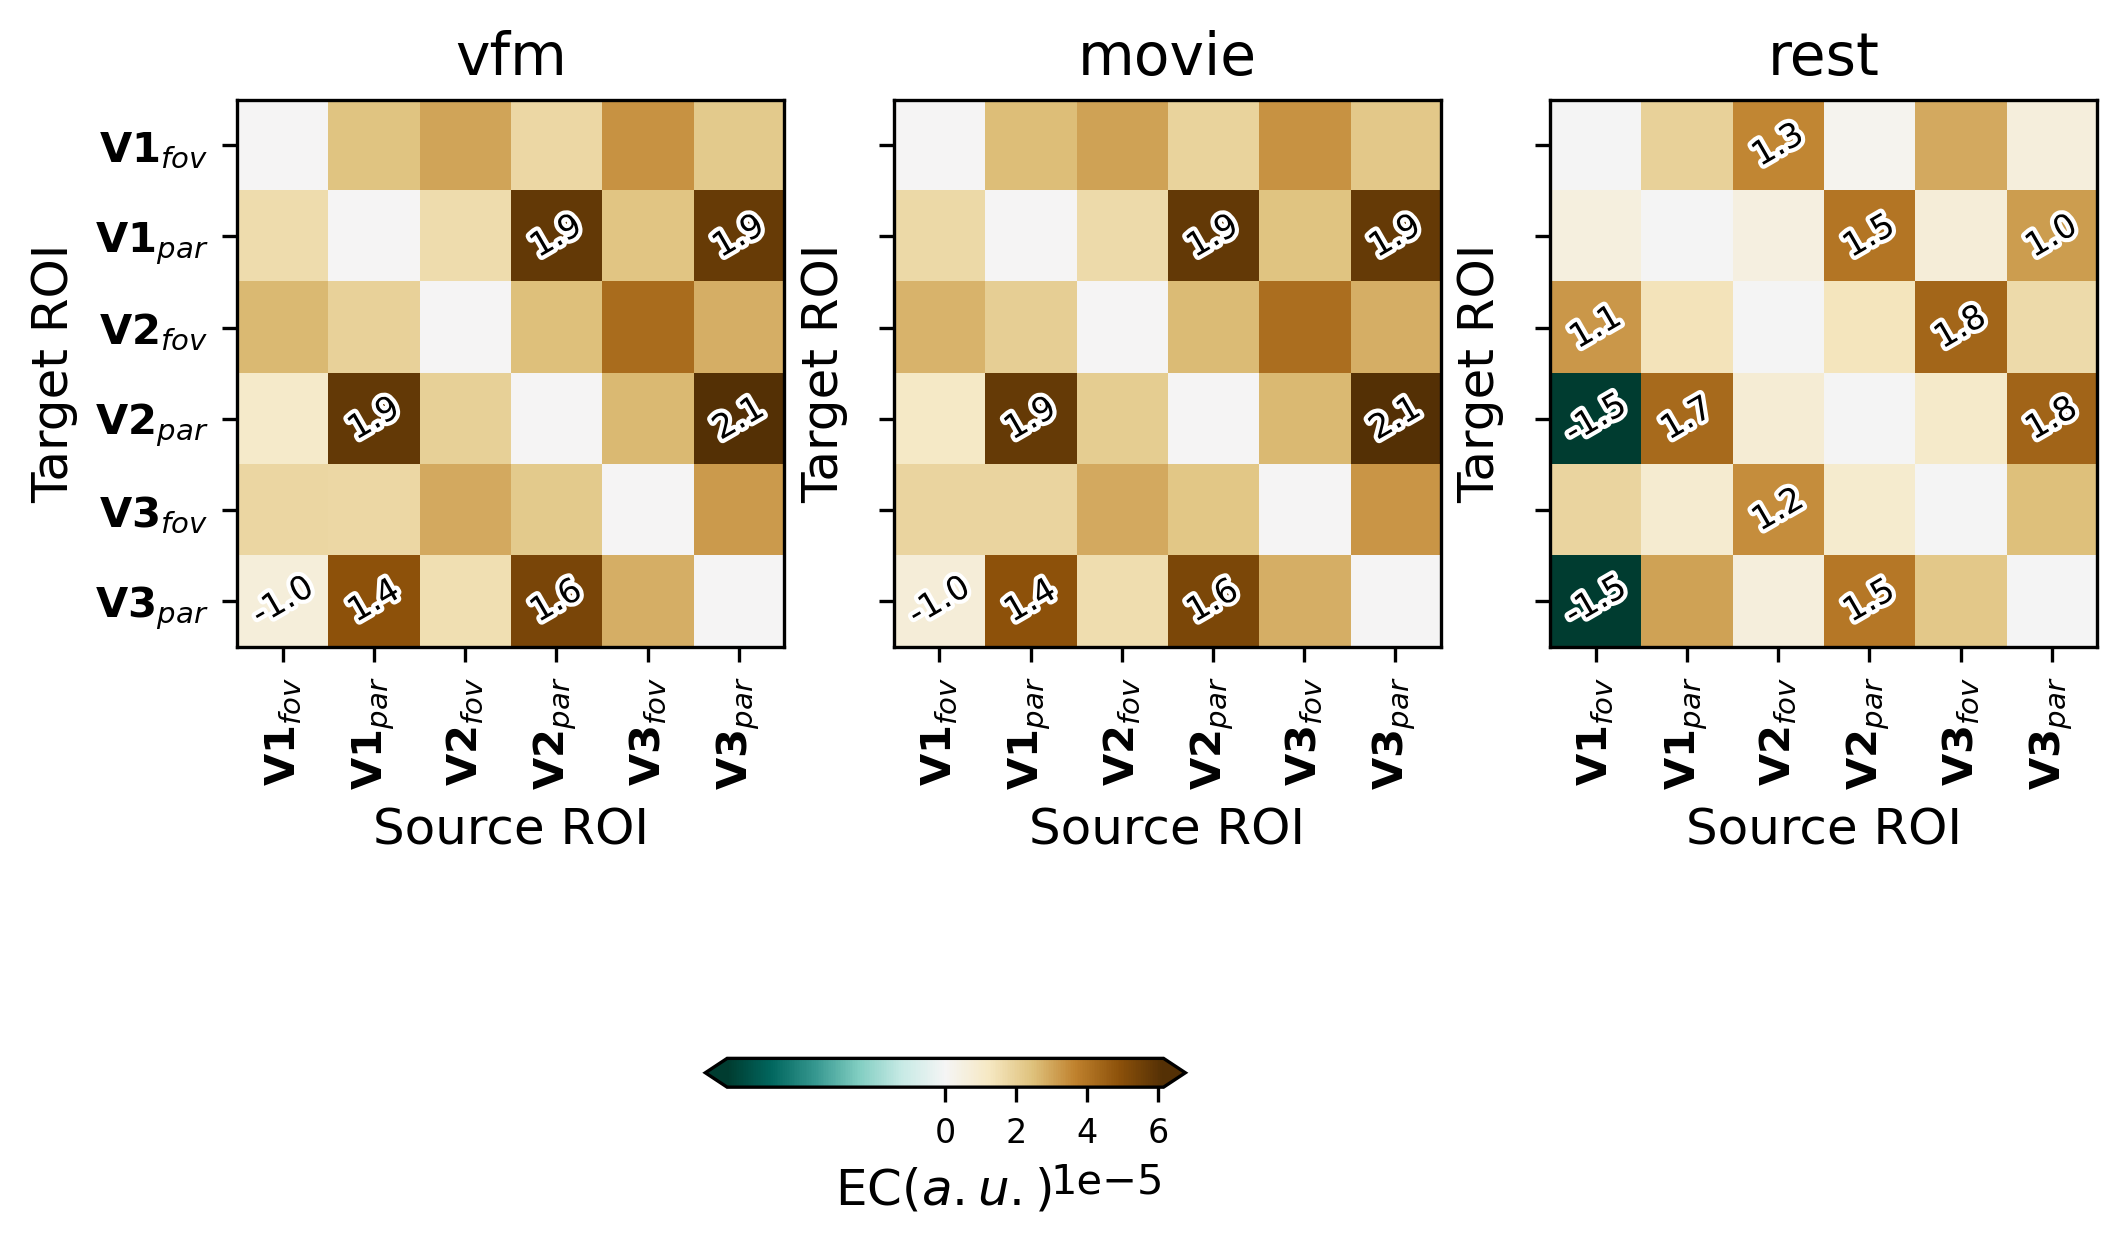

In [54]:
n_rois = 6
rois_sorted = [
        '$\mathbf{V1}_{fov}$',
        '$\mathbf{V1}_{par}$',
        '$\mathbf{V2}_{fov}$', 
        '$\mathbf{V2}_{par}$',
        '$\mathbf{V3}_{fov}$',
        '$\mathbf{V3}_{par}$'
        ]

idx_v1      = conf['rois'][0]
idx_v2      = conf['rois'][1]
idx_v3      = conf['rois'][2]

idx_fovea   = conf['fovea'][0]
idx_parafov = conf['fovea'][1]

fovpar_idx = np.zeros((6,4))

c = -1

EC_fovpar = np.zeros([n_cond,2*n_sub,6,6])

for i_roi in range(3):
    
    for i_ecc in range(2):
        c = c + 1
        ia = conf['rois'][i_roi] 
        #print(ia)  
        ib = conf['fovea'][i_ecc]
        #print(ib)
        idx = np.intersect1d(ia,ib)
        #print(idx)
        #print(ia[idx])
        fovpar_idx[c,:] = idx

#print(fovpar_idx)   


for i_cond in range(3):
    for i_sub in range(2*n_sub): 
        for i_roi in range(len(rois_sorted)):
            i_idx = list(fovpar_idx[i_roi,:].astype(int)) 
            for j_roi in range(len(rois_sorted)):
                j_idx = list(fovpar_idx[j_roi,:].astype(int)) 
                EC_fovpar[i_cond,i_sub,i_roi,j_roi] = np.nanmean(EC_hemis[i_cond,i_sub,i_idx[0:2],j_idx[0:2]].flatten())



effect_sizes = np.zeros((n_cond,n_rois,n_rois))



fig, ax = plt.subplots(1,n_cond, figsize=(8,4), dpi=300,facecolor="w")

EC_min  = np.amin(np.mean(EC_fovpar,axis=1).flatten())
EC_max  = np.amax(np.mean(EC_fovpar,axis=1).flatten())



# Compute Coehens d effect sizes
for i_cond in range(n_cond):

    for roi_p in range(n_rois):
        for roi_q in range(n_rois):
            effect_sizes[i_cond,roi_p,roi_q] = cohen_d(EC_fovpar[i_cond,:,roi_p,roi_q],EC_fovpar[i_cond,:,:,:].flatten())

        
    #im = ax[i_cond].imshow(np.mean(EC_fovpar[i_cond,:,:,:],axis=0),cmap='Greys')
    #im = ax[i_cond].imshow(np.mean(EC_fovpar[i_cond,:,:,:],axis=0),vmin=EC_min, vmax=EC_max,cmap='Greys')
    #im = ax[i_cond].imshow(np.mean(EC_normed[i_cond,:,:,:],axis=0),cmap='Greys')
    divnorm = colors.TwoSlopeNorm(vmin=EC_min, vcenter=0, vmax=EC_max)

    im = ax[i_cond].imshow(np.mean(EC_fovpar[i_cond,:,:,:],axis=0).T, norm=divnorm, cmap='BrBG_r')
    
    for roi_p in range(n_rois):
        for roi_q in range(n_rois):
            if effect_sizes[i_cond,roi_p,roi_q] >= effect_size_threshold or effect_sizes[i_cond,roi_p,roi_q] <= -effect_size_threshold:
                if roi_p > roi_q:
                    txt = ax[i_cond].text(roi_p, roi_q, f'{effect_sizes[i_cond,roi_p,roi_q]:.1f}', ha='center', va='center', color='k', fontsize=8, rotation=30)
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                if roi_p < roi_q:
                    txt = ax[i_cond].text(roi_p, roi_q, f'{effect_sizes[i_cond,roi_p,roi_q]:.1f}', ha='center', va='center', color='k', fontsize=8, rotation=30)
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            
    ax[i_cond].set_xlabel('Source ROI', fontsize=12)
    ax[i_cond].set_xticks(np.arange(len(rois_sorted)))
    ax[i_cond].set_xticklabels(labels=rois_sorted, rotation=90)
    ax[i_cond].set_ylabel('Target ROI', fontsize=12)
    ax[i_cond].set_yticks(np.arange(len(rois_sorted)))
    ax[i_cond].set_yticklabels(labels=rois_sorted, rotation=0)
    if i_cond != 0:
        ax[i_cond].set_yticks(np.arange(len(rois_sorted)))
        ax[i_cond].set_yticklabels(labels=rois_sorted, rotation=0)
        labels = [item.get_text() for item in ax[i_cond].get_yticklabels()]
        empty_string_labels = ['']*len(labels)
        ax[i_cond].set_yticklabels(empty_string_labels)
    ax[i_cond].set_title(conf['tasks'][i_cond], fontsize=14)
    shift = 0#i_cond*0.425
    if i_cond == 0:
        cbar = plt.colorbar(im,cax = fig.add_axes([0.32+shift, -0.1, 0.2, 0.024 ]),extend='both',orientation='horizontal')     
        cbar.ax.tick_params(labelsize=8)
        #cbar.set_label('Directed connectivity ($a.u.$) ',fontsize=12)
        cbar.set_label('EC($a.u.$) ',fontsize=12)

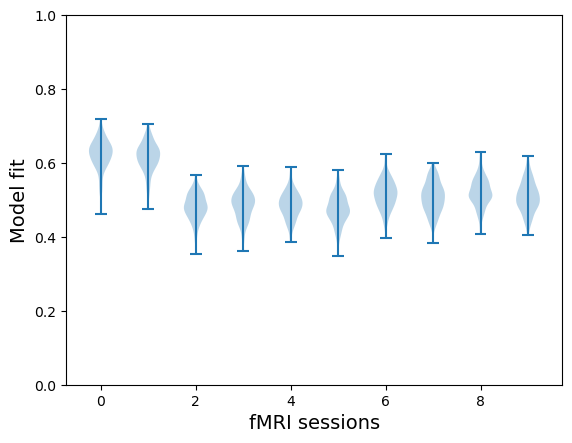

In [60]:
plt.figure()
plt.violinplot(EC_r2adj.T,positions=range(10))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions', fontsize=14)
plt.ylabel('Model fit', fontsize=14)
plt.show()

#plt.figure()
#plt.violinplot(model_error.T,positions=range(n_cond))
#plt.axis(ymin=0,ymax=1)
#plt.xlabel('fMRI sessions', fontsize=14)
#plt.ylabel('Model error', fontsize=14)
#plt.show()

Test difference asymmetry EC ret - mov: MannwhitneyuResult(statistic=11965.0, pvalue=0.7993666701288018)
Test difference asymmetry EC ret - rest: MannwhitneyuResult(statistic=10327.0, pvalue=0.020882943029713382)
Test difference asymmetry EC mov - rest: MannwhitneyuResult(statistic=12371.0, pvalue=0.7993666701288018)


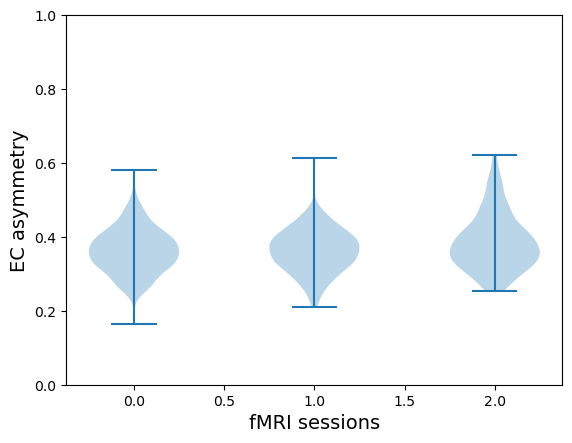

In [58]:
n_rois = 24

def asym(X):
    return np.abs(X-X.T).sum() / np.abs(X).sum() / 2

n_sub = EC_normed.shape[1]

asym_EC = np.zeros([n_sub,n_cond])
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        C_tmp = EC_normed[i_cond,i_sub,:,:] # changed to normed
        C_tmp[np.eye(n_rois,dtype=bool)] = 0
        asym_EC[i_sub,i_cond] = asym(C_tmp)

print( 'Test difference asymmetry EC ret - mov:', 
       stats.mannwhitneyu(asym_EC[:,0].flatten(), asym_EC[:,1].flatten()) )
print( 'Test difference asymmetry EC ret - rest:', 
       stats.mannwhitneyu(asym_EC[:,0].flatten(), asym_EC[:,2].flatten()) )
print( 'Test difference asymmetry EC mov - rest:', 
       stats.mannwhitneyu(asym_EC[:,1].flatten(), asym_EC[:,0].flatten()) )
        
    
plt.figure()
plt.violinplot(asym_EC,positions=range(n_cond))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions', fontsize=14)
plt.ylabel('EC asymmetry', fontsize=14)

plt.show()